# Convolutional Neural Network for Handwriting Detection

**Project:** Handwriting Detection System

**Class:** CPT_S 437 Machine Learning

**Team Members:** Molly Iverson, Caitlin Graves, Chandler Juego

## Summary

### Model Overview
Convolutional Neural Network (CNN) is a type of deep learning algorithm specifically designed for image recognition and processing, making it ideal for tasks like feature extraction and classification of handwritten characters using the MNIST dataset. The CNN architecture leverages convolutional layers to automatically extract spatial features, pooling layers to reduce spatial dimensions, and dense layers to perform final classification.


---

### Dataset

- **Source**: MNIST (Modified National Institute of Standards and Technology) Dataset  
- **Description**: Handwritten digit images  
- **Dimensions**: 28x28 pixel grayscale images  
- **Classes**: 10 digits (0-9)  
- **Training Set Size**: 60,000 images  
- **Test Set Size**: 10,000 images  

---

## Network Architecture

- **Input Layer**: 28x28 grayscale images (reshaped to 28x28x1)  
- **Layer 1: Convolutional Layer**
  - Filters: 64  
  - Kernel Size: 3x3  
  - Activation: ReLU  
  - **Pooling**: MaxPooling with a 2x2 pool size  
- **Layer 2: Convolutional Layer**
  - Filters: 64  
  - Kernel Size: 3x3  
  - Activation: ReLU  
  - **Pooling**: MaxPooling with a 2x2 pool size  
- **Layer 3: Flattening Layer**  
  - Converts 2D feature maps to 1D feature vectors.  
- **Layer 4: Dense Layer**
  - Neurons: 64  
  - Activation: ReLU  
  - Dropout: 50% to prevent overfitting  
- **Output Layer**
  - Neurons: 10 (corresponding to the 10 digit classes: 0-9)  
  - Activation: Softmax for multi-class probability distribution.  

---

## Techniques

### Preprocessing Data
- **Channel Expansion**: Added a channel dimension to adapt grayscale images for Conv2D input, reshaping data to (28, 28, 1).  
- **Pixel Normalization**: Scaled pixel values from [0, 255] to [0, 1] for stable model convergence.

### Model Techniques
- **Activation Functions**  
  - **ReLU Activation**: Applied in all hidden layers to introduce non-linearity and improve gradient flow.  
  - **Softmax Activation**: Used in the output layer for probability distribution across digit classes.  
- **Dropout Regularization**  
  - Prevents overfitting by randomly dropping 50% of neurons in the dense layer during training.  
- **Pooling**: MaxPooling reduces spatial dimensions while retaining essential features, improving computational efficiency.  

### Loss Function
- **Sparse Categorical Cross-Entropy**  
  - Measures prediction error for multi-class classification tasks, penalizing incorrect predictions based on log probabilities.

### Optimization Strategies
- **Adam Optimizer**  
  - Combines adaptive learning rates with momentum, ensuring efficient and stable gradient descent.  
- **Mini-Batch Gradient Descent**  
  - Processes batches of 128 samples at a time to balance computational efficiency and training stability.  
- **Early Stopping**  
  - Monitors validation performance to halt training early, preventing overfitting.

---

## Results

- **Test Accuracy**: Achieved an accuracy of approximately 97.72% on the MNIST test set after 5 epochs of training.  
- **Validation Accuracy**: Demonstrated consistent performance with minimal overfitting due to dropout regularization.

---

## Advantages of CNN for Handwriting Detection
1. **Efficient Feature Extraction**: Convolutional layers automatically learn spatial hierarchies, reducing the need for manual feature engineering.  
2. **Robust to Local Translations**: Pooling layers ensure stability across small spatial variations in input.  
3. **Scalability**: Suitable for large-scale image datasets beyond MNIST due to its efficient architecture.

---


## Data Processing


Import dependencies


In [15]:
from array import array
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import random
import struct

Download the MNIST dataset

In [16]:
# Download latest version of dataset
input_path = kagglehub.dataset_download('hojjatk/mnist-dataset')

print('Path to dataset files:', input_path)

training_images_filepath = input_path + '/train-images.idx3-ubyte'
training_labels_filepath = input_path + '/train-labels.idx1-ubyte'
test_images_filepath = input_path + '/t10k-images.idx3-ubyte'
test_labels_filepath = input_path + '/t10k-labels.idx1-ubyte'

Path to dataset files: /root/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


Process the dataset

* Resize and normalize the images to a standard 28x28 pixels
* Scale pixal values to be between 1 and 0

In [17]:
class MnistLoader:
    def __init__(self, train_img_path, train_lbl_path, test_img_path, test_lbl_path):
        self.train_img_path = train_img_path
        self.train_lbl_path = train_lbl_path
        self.test_img_path = test_img_path
        self.test_lbl_path = test_lbl_path

    def load_images(self, img_path):
        with open(img_path, 'rb') as f:
            magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
            # this dataset uses a value called "magic" to represent the type and structure of data stored in each file
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", f.read())
            images = np.array(image_data, dtype=np.uint8).reshape(size, rows, cols)
        return images

    def load_labels(self, lbl_path):
        with open(lbl_path, 'rb') as f:
            magic, size = struct.unpack(">II", f.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = np.array(array("B", f.read()), dtype=np.int8)
        return labels

    def load_data(self):
        x_train = self.load_images(self.train_img_path)
        y_train = self.load_labels(self.train_lbl_path)
        x_test = self.load_images(self.test_img_path)
        y_test = self.load_labels(self.test_lbl_path)
        return (x_train, y_train), (x_test, y_test)

    def preprocess_images(self, images, new_size=(28, 28)):
        processed_images = []
        for img in images:
            pil_img = Image.fromarray(img)
            resized_img = pil_img.resize(new_size)
            normalized_img = np.array(resized_img) / 255.0  # Normalize pixel values
            processed_images.append(normalized_img)
        return np.array(processed_images)

Show some letter images

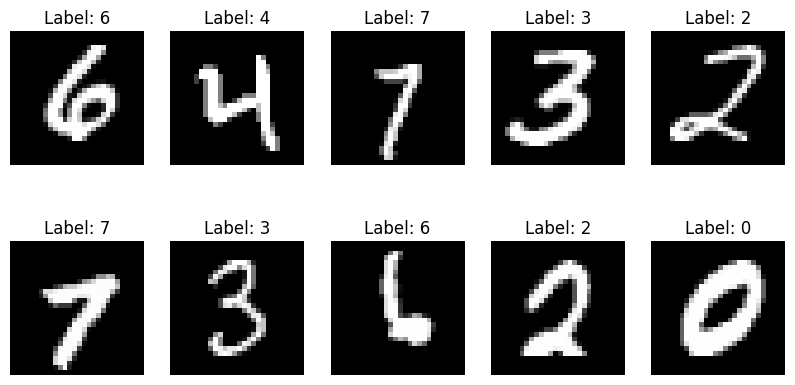

In [18]:
# Initialize and load the data
mnist_loader = MnistLoader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_loader.load_data()

# Preprocess images (resize and normalize)
x_train_processed = mnist_loader.preprocess_images(x_train)
x_test_processed = mnist_loader.preprocess_images(x_test)

# Display some sample images with their labels
def display_samples(images, labels, num_samples=10):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        idx = random.randint(0, len(images) - 1)
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"Label: {labels[idx]}")
        plt.axis('off')
    plt.show()

# Show random sample images from training data
display_samples(x_train_processed, y_train)

# CNN

## Training

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

# Add a channels dimension to the data for Conv2D to work
x_train_processed = x_train_processed[..., np.newaxis]
x_test_processed = x_test_processed[..., np.newaxis]

x_train_processed, x_val, y_train, y_val = train_test_split(
    x_train_processed, y_train, test_size=0.1, random_state=42  # 10% for validation
)

# Build the model
model = Sequential()

# First convolutional layer
model.add(Conv2D(64, (3,3), input_shape=x_train_processed.shape[1:]))  # Shape is (28, 28, 1) for MNIST
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# Second convolutional layer
model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flattening layer and dense layers
model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))

# Output layer for 10 classes (digits 0-9) with softmax activation
model.add(Dense(10))
model.add(Activation('softmax'))

# Compile the model with a categorical cross-entropy loss
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

# Train with early stopping
history = model.fit(x_train_processed, y_train, batch_size=128, epochs=5, validation_data=(x_val, y_val))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 88s 206ms/step - accuracy: 0.7164 - loss: 0.8465 - val_accuracy: 0.9777 - val_loss: 0.0823
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 135s 190ms/step - accuracy: 0.9495 - loss: 0.1685 - val_accuracy: 0.9822 - val_loss: 0.0612
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 83s 196ms/step - accuracy: 0.9641 - loss: 0.1179 - val_accuracy: 0.9872 - val_loss: 0.0474
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 81s 193ms/step - accuracy: 0.9717 - loss: 0.0980 - val_accuracy: 0.9882 - val_loss: 0.0421
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 80s 188ms/step - accuracy: 0.9769 - loss: 0.0790 - val_accuracy: 0.9882 - val_loss: 0.0422


## Evaluation


In [20]:
test_loss, test_acc = model.evaluate(x_test_processed, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.8f}")

final_val_accuracy = history.history['val_accuracy'][-1]
print(f"Final validation accuracy: {final_val_accuracy:.8f}")



Test accuracy: 0.98780000
Final validation accuracy: 0.98816669


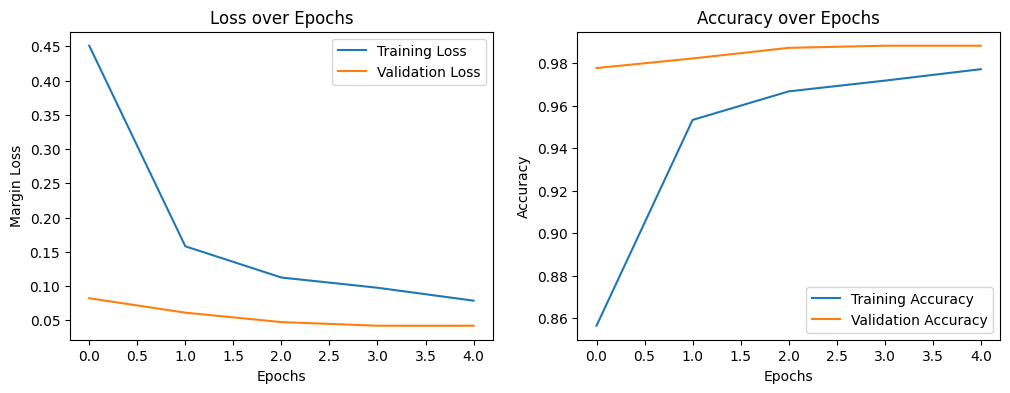

In [21]:
import matplotlib.pyplot as plt

# Plotting Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Margin Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import classification_report

# Predict on test data
Y_pred = model.predict(x_test_processed)

# Convert predictions to class labels
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = y_test

# Classification report
print("Classification Report:\n")
print(classification_report(Y_true, Y_pred_classes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.97      0.99      0.98      1028
           8       0.99      0.98      0.99       974
           9       1.00      0.96      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



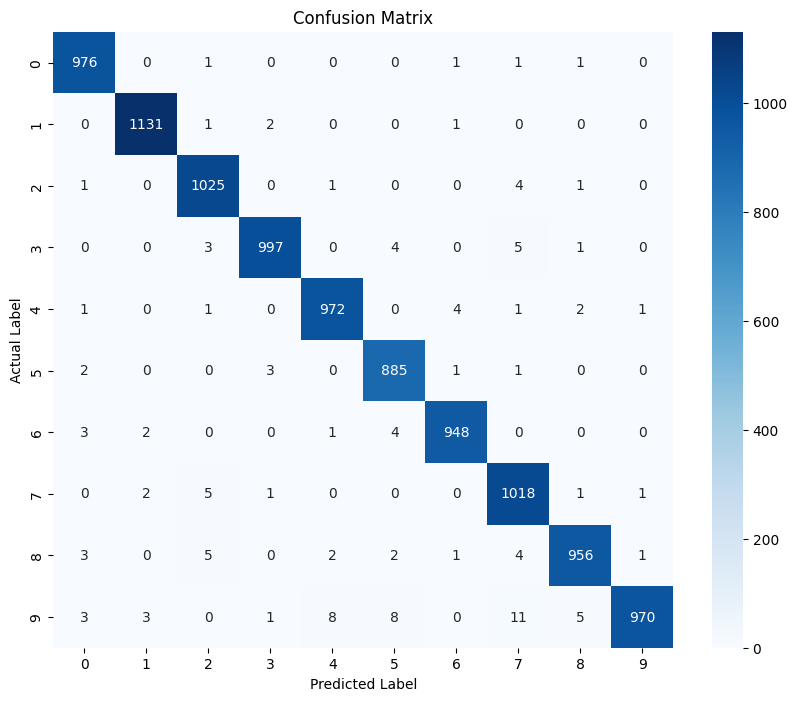

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

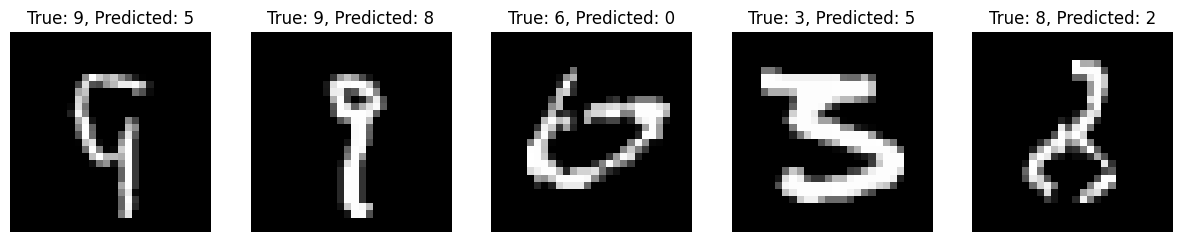

In [24]:
# Find misclassified examples
misclassified_idx = np.where(Y_pred_classes != Y_true)[0]

# Plot some misclassified examples
num_examples = 5
plt.figure(figsize=(15,15))
for i in range(num_examples):
    idx = misclassified_idx[i]
    img = x_test_processed[idx].reshape(28,28)
    plt.subplot(1, num_examples, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {Y_true[idx]}, Predicted: {Y_pred_classes[idx]}")
    plt.axis('off')
plt.show()

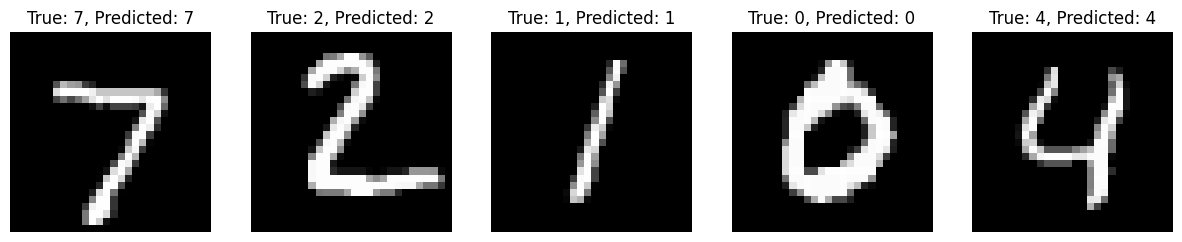

In [25]:
# Find correctly classified examples
correctly_classified_idx = np.where(Y_pred_classes == Y_true)[0]

# Plot some correctly classified examples
num_examples = 5
plt.figure(figsize=(15, 15))
for i in range(num_examples):
    idx = correctly_classified_idx[i]
    img = x_test_processed[idx].reshape(28, 28)
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {Y_true[idx]}, Predicted: {Y_pred_classes[idx]}")
    plt.axis('off')
plt.show()